# Focal Loss + 自定义评估函数
## 基于Mnist数据集上的实战

注意：没有GPU来基于Mnist运行模型，虽然不会烧坏CPU，但是速度很慢
之前花了一天的功夫，重新安装好了GPU版本

为了能运行大数据：
- 即使安装了GPU版本，电脑还是出现了散热扇疯狂工作的情况
- 关键步骤使用@tf.function将动态图转化为静态图


In [70]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available()) #测试是都

2.0.0
True


In [71]:
# help(tf.clip_by_value)

In [86]:
#多分类的focal loss 损失函数
# SparseFocalLoss接受序号编码的y_ture
class SparseFocalLoss(tf.keras.losses.Loss):

    def __init__(self,gamma=2.0,class_num=10):
        self.gamma = gamma
        self.class_num = class_num 
        super(SparseFocalLoss, self).__init__()

    def call(self,y_true,y_pred):

        #因为预测值为0，会造成对数计算失败
        epsilon = tf.keras.backend.epsilon()#1e-07
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0)#将y_pred限制在（epsilon,1）的数值范围内
        
        y_true = tf.one_hot(y_true,depth=self.class_num)#将label多类转化为多维onehot的情况
        y_true = tf.cast(y_true,tf.float32)#类型转化
        
        loss = -  y_true * tf.math.pow(1 - y_pred, self.gamma) * tf.math.log(y_pred)
        
        loss_value = tf.math.reduce_sum(loss,axis=1)#reduce_sum是加和求平均的意思
        return loss_value

# Focal Loss对应的y_true是one-hot编码形式
class FocalLoss(tf.keras.losses.Loss):

    def __init__(self,gamma=2.0,class_num=10):
        self.gamma = gamma
        self.class_num = class_num 
        super(FocalLoss, self).__init__()

    def call(self,y_true,y_pred):

        #因为预测值为0，会造成对数计算失败
        epsilon = tf.keras.backend.epsilon()#1e-07
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0)#将y_pred限制在（epsilon,1）的数值范围内
        
#         y_true = tf.one_hot(y_true,depth=self.class_num)#不需要将y_true来进行one-hot编码
        y_true = tf.cast(y_true,tf.float32)#类型转化
        
        loss = -  y_true * tf.math.pow(1 - y_pred, self.gamma) * tf.math.log(y_pred)
        
        loss_value = tf.math.reduce_sum(loss,axis=1)#reduce_sum是加和求平均的意思
        return loss_value

In [73]:
# focalloss = SparseFocalLoss(gamma=2.0,class_num=3)
# a=focalloss(tf.constant([0,1,2]),
#          tf.constant([[0.01,0.02,0.9],[0.4,0.7,0.01],[0.5,0.6,0.1]]))
# tf.print(a)
# #学习类：类声明（首字母大写），__init__初始参数；call返回输入的变量；类调用,f=类（初始参数），f(输入变量)

### tf.keras.metrics
tf.keras.metrics.BinaryAccuracy 类的实现形式
tf.keras.metrics.binary_accuracy 函数实现形式

还有分类的评估函数
tf.keras.metics.MeanSquaredError
tf.keras.metics.MeanAbsoluteError

！！！上述与机器学习算法相同

tf.keras.metrics.CategorialAccuracy(分类准确性，y_true要求onehot编码形式)
tf.keras.metrics.SparseCategorialAccuracy(稀疏分类准确性，y_true要求是序号编码形式)

！！！两者区别需要注意，对于y_true的要求格式不同


In [119]:
# 定义一个评估函数，返回的是一个有权重的正确的个数,而不是比重

class CatgoricalTruePositives(tf.keras.metrics.Metric):
    def __init__(self, class_num=10,name='categorical_true_positives', **kwargs):
        self.class_num = class_num 
        super(CatgoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred,axis=-1)#返回最大值对应的index
        y_pred=tf.one_hot(y_pred, depth=self.class_num)
        
        values = tf.equal(tf.cast(y_true, 'int32'), tf.cast(y_pred, 'int32'))
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)#处理权重对于结果的影响
        self.true_positives.assign_add(tf.reduce_sum(values)) #在现有结果上加上新的计算，而不是直接赋值

    def result(self):
        return self.true_positives

    def reset_states(self):
        self.true_positives.assign(0.)

In [107]:
help(tf.argmax)

Help on function argmax_v2 in module tensorflow.python.ops.math_ops:

argmax_v2(input, axis=None, output_type=tf.int64, name=None)
    Returns the index with the largest value across axes of a tensor.
    
    Note that in case of ties the identity of the return value is not guaranteed.
    
    For example:
    ```python
    A=tf.constant([2,20,30,3,6]) # Constant 1-D Tensor
    tf.math.argmax(A) # output 2 as index 2 (A[2]) is maximum in tensor A
    B=tf.constant([[2,20,30,3,6],[3,11,16,1,8],[14,45,23,5,27]])
    tf.math.argmax(B,0) # [2, 2, 0, 2, 2]
    tf.math.argmax(B,1) # [2, 2, 1]
    ```
     
    Args:
      input: A `Tensor`. Must be one of the following types: `float32`, `float64`,
        `int32`, `uint8`, `int16`, `int8`, `complex64`, `int64`, `qint8`,
        `quint8`, `qint32`, `bfloat16`, `uint16`, `complex128`, `half`, `uint32`,
        `uint64`.
      axis: A `Tensor`. Must be one of the following types: `int32`, `int64`.
        int32 or int64, must be in the range 

In [75]:
# help(tf.keras.metrics.Metric)

In [76]:
# eval_func = CatgoricalTruePositives()
# eval_func(tf.constant([0,1,2]),
#          tf.constant([0,1,3]))
# # tf.print(m)
# tf.print(eval_func.result().numpy())
# eval_func.reset_states()#感觉并没有将m的值设置为0的功能；不知道有什么用
# # 我并不会应用这个类

1.0


### 基于Mnist数据集建模(自定义模型、keras模型)
1. 下载并探究Mnist
2. 处理输入输出，训练验证测试
3. 构建模型：输入（28x28x1）-->CNN--》flatten--》dense-->dense(10)
4. 损失函数、优化器、评估函数
5. 运行模型

##### 下载并探究Mnist

In [77]:
import numpy as np
mnist = np.load("mnist.npz")
x_train, y_train, x_test, y_test = mnist['x_train'],mnist['y_train'],mnist['x_test'],mnist['y_test']

In [78]:
# mnist是6万张训练图片和1万张测试图片，每张图片的大小是28*28
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [79]:
# help(ax.flatten)

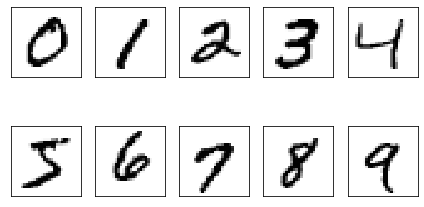

In [80]:
# 如何预览一下这个数据呢
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(
    nrows=2,
    ncols=5,
    sharex=True,
    sharey=True, )#显示的设置：2行5列

ax = ax.flatten()
for i in range(10):
    img = x_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### 2. 处理输入输出，训练验证测试

In [81]:
# 数据处理
x_train, x_test = x_train / 255.0, x_test / 255.0 #要求对特征进行归一化，因为最大值是255，只要除以255就好了
y_train = np.int32(y_train)
y_test = np.int32(y_test)
# Add a channels dimension
x_train = x_train[..., tf.newaxis]#新增的newaxis代表是色彩，如果是1，那么是黑白；如果是3，代表是彩色。
x_test = x_test[..., tf.newaxis]

#one-hot转化，这一步取决于后续评估函数，如果是categorialAccuracy,那么久需要onehot编码形式
y_train = tf.one_hot(y_train,depth=10)
y_test = tf.one_hot(y_test,depth=10)

#划分为32batch
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(100).batch(32)

### 3 构建模型：输入（28x28x1）-->CNN--》flatten--》dense-->dense(10)
mykerasmodel 是使用tf.keras.Model打包;
myDefinedModel 是继承父类tf.keras.Model

In [82]:
def MyKerasModel():
    inputs = tf.keras.Input(shape=(28,28,1), name='digits')
    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(10,activation='softmax', name='predictions')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [83]:
class MyDefinedModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

In [120]:
mymodel=MyKerasModel()
# mymodel=MyDefinedModel()

#损失函数
# loss_object = tf.keras.losses.CategoricalCrossentropy()
loss_object = FocalLoss()

#优化器
optimizer=tf.keras.optimizers.Adam()

#损失函数
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
train_tp=CatgoricalTruePositives(name='train_tp')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')
test_tp=CatgoricalTruePositives(name='test_tp')



In [123]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = mymodel(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, mymodel.trainable_variables)
    optimizer.apply_gradients(zip(gradients, mymodel.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    train_tp(labels,predictions)


@tf.function
def test_step(images, labels):
    predictions = mymodel(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    test_tp(labels,predictions)

In [125]:
EPOCHS = 5
for epoch in range(EPOCHS):
    # 在下一个epoch开始时，重置评估指标
    train_loss.reset_states()
    train_accuracy.reset_states()
    train_tp.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    test_tp.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Tp:{}, Test Loss: {}, Test Accuracy: {}, Test Tp:{}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          train_tp.result(),
                          test_loss.result(),
                          test_accuracy.result() * 100,
                         test_tp.result()))


Epoch 1, Loss: 0.002750168554484844, Accuracy: 99.75167083740234, Tp:599702.0, Test Loss: 0.03827527165412903, Test Accuracy: 98.0999984741211, Test Tp:99620.0
Epoch 2, Loss: 0.002412648405879736, Accuracy: 99.76000213623047, Tp:599712.0, Test Loss: 0.03190673887729645, Test Accuracy: 98.41999816894531, Test Tp:99684.0
Epoch 3, Loss: 0.001734148128889501, Accuracy: 99.8116683959961, Tp:599774.0, Test Loss: 0.02965480089187622, Test Accuracy: 98.43999481201172, Test Tp:99688.0
Epoch 4, Loss: 0.0011369034182280302, Accuracy: 99.88333892822266, Tp:599860.0, Test Loss: 0.036331597715616226, Test Accuracy: 98.25999450683594, Test Tp:99652.0
Epoch 5, Loss: 0.0011007529683411121, Accuracy: 99.9000015258789, Tp:599880.0, Test Loss: 0.03335016593337059, Test Accuracy: 98.54000091552734, Test Tp:99708.0
